<p><img alt="Colaboratory logo" height="140px" src="https://upload.wikimedia.org/wikipedia/commons/archive/f/fb/20161010213812%21Escudo-UdeA.svg" align="left" hspace="10px" vspace="0px"></p>

# **Predicción sobre días lluviosos con árboles de decisión y modelos de ensamble**



# Lucas Quiceno.
# Victor Oviedo.

In [ ]:
#@title
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, validation_curve, cross_val_score, GridSearchCV
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from xgboost import XGBClassifier

Para hacer el análisis del dataset, lo primero que se debe hacer es un análisis exploratorio que nos permita conocer nuestros datos para su análisis posterior.

In [ ]:
#@title
data = pd.read_csv('weatherAUS.csv', sep=',') 
data

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


La información del dataset

In [ ]:
#@title
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

Con `isnull` miramos los elementos faltantes por columna. 

In [ ]:
#@title
missing_values_count = data.isnull().sum() 
missing_values_count[:]

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

Queremos separar las variables númericas y categóricas, por eso, separarmos nuestro datos en `num_data` que contiene variables númericas y `cat_data` que contiene variables categóricas. Con `select_dtypes` nos permite escoger varibales númericas.

In [ ]:
#@title
num_data=data.select_dtypes(include=np.number).columns.tolist()
num_data

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm']

In [ ]:
#@title
cat_data=data.select_dtypes(object).columns.tolist()
cat_data

['Date',
 'Location',
 'WindGustDir',
 'WindDir9am',
 'WindDir3pm',
 'RainToday',
 'RainTomorrow']

Empleando `heatmap` nos entrega una gráfica de calor dónde los valores faltantes se ven en blanco.

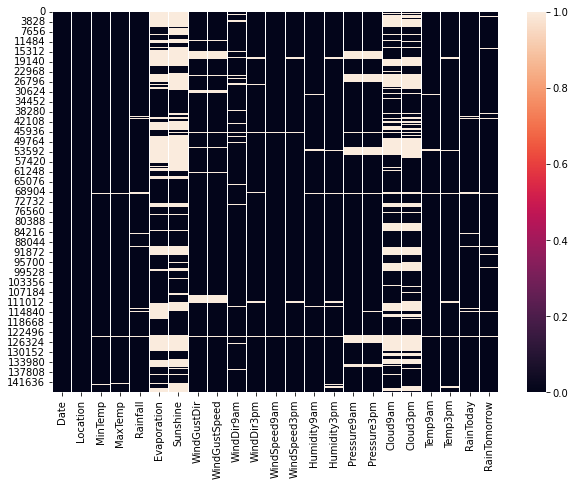

In [ ]:
#@title
plt.figure(figsize=(10,7))
sns.heatmap(data.isnull());

Evaporation,	Sunshine, Cloud9am	y Cloud3pm son los que le hacen falta más datos. Falta gran números de datos en estas columnas, se pueden quitar con el método `drop`. Con el método `dropna` eliminamos las filas de la variables objetivo que tiene valores faltantes. Para los propósitos del proyecto no se considera relevante la posición, por lo que también se quita.

In [ ]:
#@title
data.drop(['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm', 'Location'], axis=1, inplace=True) 
data.dropna(how='all', subset=['RainTomorrow'], inplace=True) # quita filas que tiene valores faltantes de objetivo
data.dropna(how='all', subset=['RainToday'], inplace=True) #DEJAR ESTA?
cat_data=data.select_dtypes(object).columns.tolist() #se actualiza cat_data

Vemos nuevamente un diagrama de calor.

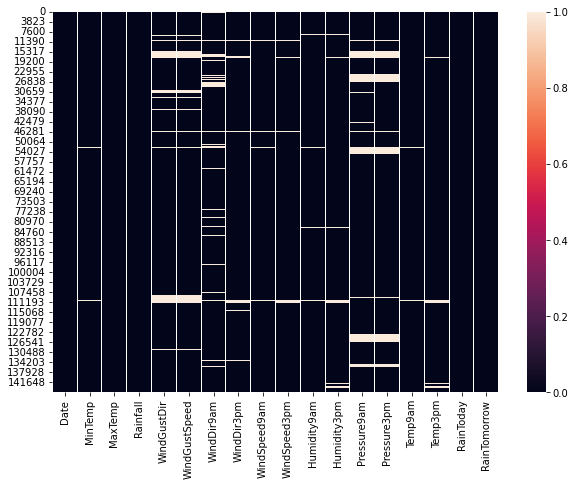

In [ ]:
#@title
plt.figure(figsize=(10,7))
sns.heatmap(data.isnull());

Hacemos un resumen de nuestras variables categóricas.

In [ ]:
#@title
print(f'Hay {len(cat_data)} caracteristicas categoricas que incluyen: "\n" {cat_data} \n')
for i in cat_data:
    NumUnico = data[i].nunique()
    NomUnico = data[i].unique().tolist()
    print(f'{i} tiene {NumUnico} variables unicas que incluyen :')
    print(f'{NomUnico} \n')

Hay 6 caracteristicas categoricas que incluyen: "
" ['Date', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow'] 

Date tiene 3436 variables unicas que incluyen :
['2008-12-01', '2008-12-02', '2008-12-03', '2008-12-04', '2008-12-05', '2008-12-06', '2008-12-07', '2008-12-08', '2008-12-09', '2008-12-10', '2008-12-11', '2008-12-12', '2008-12-13', '2008-12-14', '2008-12-17', '2008-12-18', '2008-12-19', '2008-12-20', '2008-12-21', '2008-12-22', '2008-12-23', '2008-12-24', '2008-12-25', '2008-12-26', '2008-12-27', '2008-12-28', '2008-12-29', '2008-12-30', '2008-12-31', '2009-01-01', '2009-01-02', '2009-01-03', '2009-01-04', '2009-01-05', '2009-01-06', '2009-01-07', '2009-01-08', '2009-01-09', '2009-01-10', '2009-01-11', '2009-01-12', '2009-01-13', '2009-01-14', '2009-01-15', '2009-01-16', '2009-01-17', '2009-01-18', '2009-01-19', '2009-01-20', '2009-01-21', '2009-01-22', '2009-01-23', '2009-01-24', '2009-01-25', '2009-01-26', '2009-01-27', '2009-01-28', '2009-01-29', '200

Ahora, nos interesa examinar nuestras variables númericas, primero usamos el método `describe` que nos entrega un resumen completo de variables númericas como media, desviación estandar...

In [ ]:
data.describe()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm
count,140319.000000,140480.00000,140787.000000,131682.000000,139732.000000,138256.000000,139270.000000,137286.000000,127044.000000,127018.000000,140131.000000,138163.000000
mean,12.184824,23.23512,2.349974,39.970520,13.990496,18.631141,68.826833,51.449288,1017.654577,1015.257963,16.987066,21.693183
std,6.403879,7.11450,8.465173,13.578201,8.886210,8.798096,19.063650,20.807310,7.104867,7.035411,6.496012,6.937784
min,-8.500000,-4.80000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,-7.200000,-5.400000
25%,7.600000,17.90000,0.000000,31.000000,7.000000,13.000000,57.000000,37.000000,1013.000000,1010.400000,12.300000,16.600000
50%,12.000000,22.60000,0.000000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,16.700000,21.100000
75%,16.800000,28.30000,0.800000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,21.600000,26.400000
max,33.900000,48.10000,371.000000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,40.200000,46.700000


Investigamos nuestras variables númericas, usando `select_dtypes` escogemos los datos de tipo `int64` y `float64`. Hacemos un diagrama de cajas al lado del histograma de cada variable.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

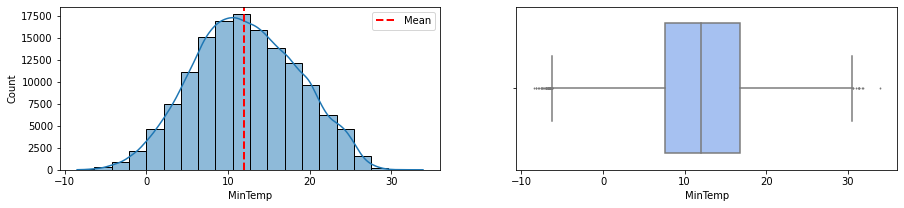

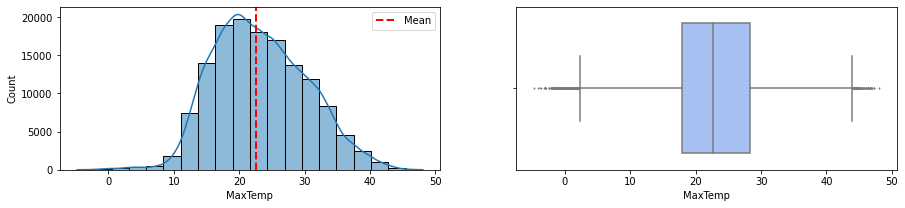

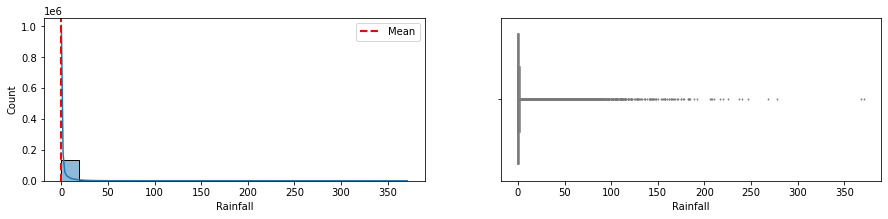

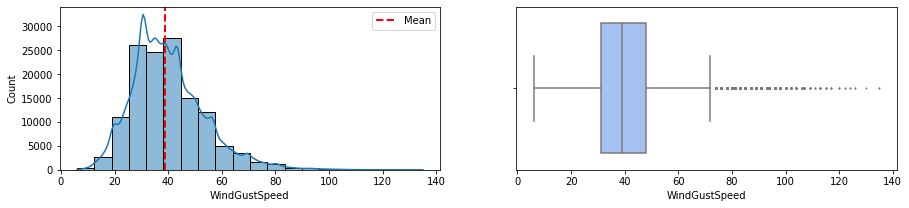

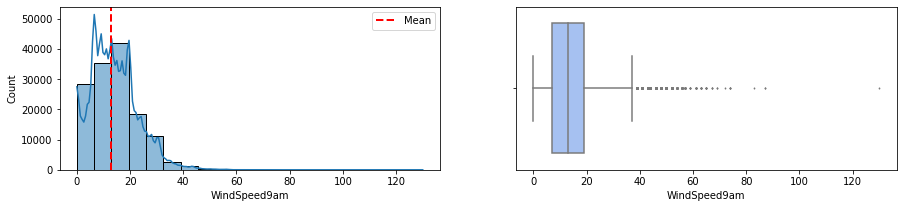

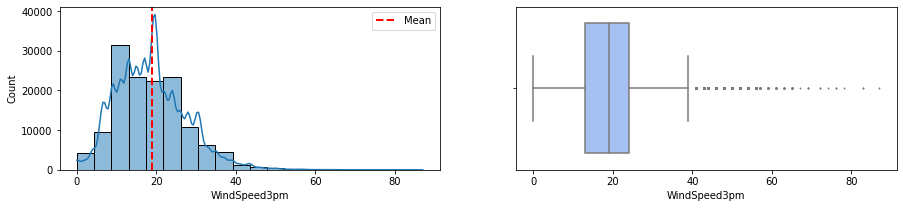

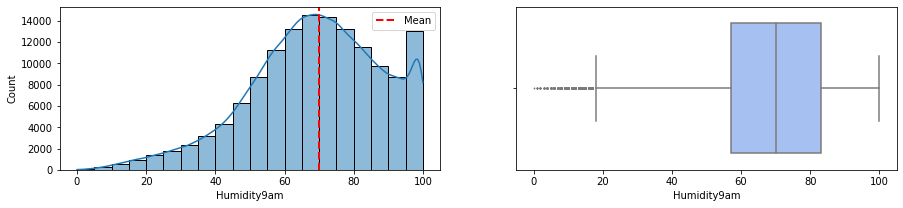

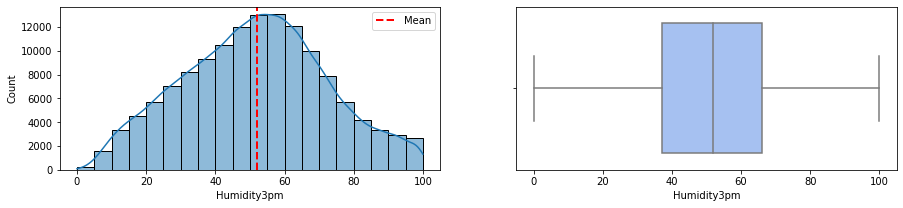

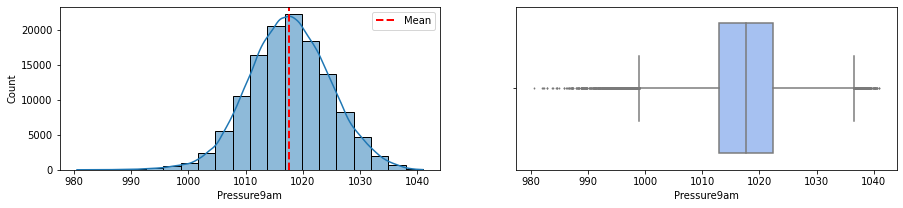

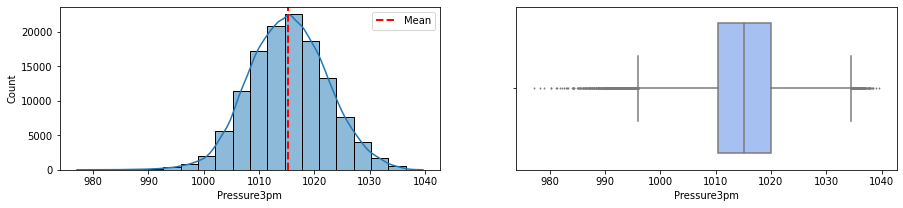

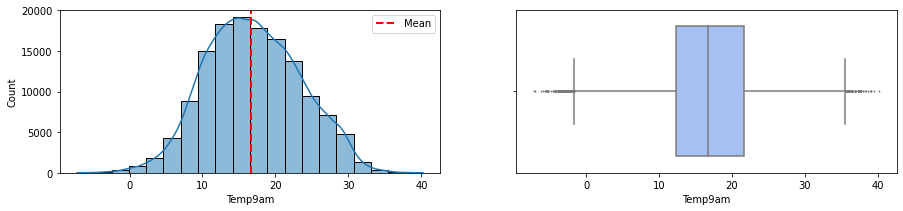

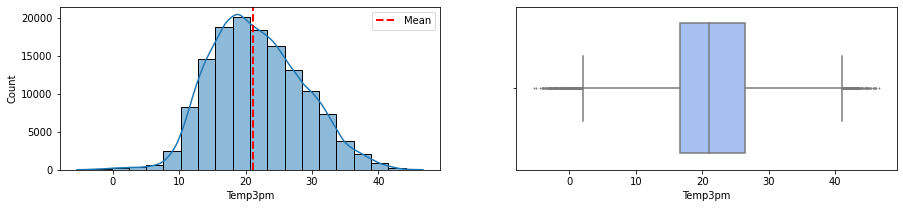

In [ ]:
#@title
num_data=data.select_dtypes(include=['int64','float64']).columns.tolist() 

for i in num_data:
   
    fig, axs = plt.subplots(1,2,figsize=(15, 3))

    sns.histplot(data[i],bins=20, kde=True,ax=axs[0]);
    sns.boxplot(data[i], ax = axs[1], color='#99befd', fliersize=1);
    
    axs[0].axvline(data[i].median(), color='r', linewidth=2, linestyle='--', label='Mean')
    axs[0].legend();

Del conjunto de graficas anteriores podemos ver que todas las variables cuentan con una escala similar, además es de tener en cuenta que su media es similar excepto la variable `Rainfall` que no aporta nada, no se puede tener una interpretación de esta variable. Por lo tanto, esta varibale se puede eliminar del conjunto de datos sin perder capacidad predictiva.

Las grafica anteriores también nos dicen que, para las variables numéricas, se pueden completar los valores faltantes con la media. Usamos para ello `SimpleImputer`

In [ ]:
#@title
imputer = SimpleImputer(strategy="mean" )
imputer

num_data=data.select_dtypes(include=np.number).columns.tolist() #se actualiza la lista 

for col in num_data:
    imputer.fit(data[[col]])
    data[col]=imputer.transform(data[[col]]).ravel()


In [ ]:
#@title
missing_values_count = data.isnull().sum() 
missing_values_count[:]

Date                0
MinTemp             0
MaxTemp             0
Rainfall            0
WindGustDir      9163
WindGustSpeed       0
WindDir9am       9660
WindDir3pm       3670
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Temp9am             0
Temp3pm             0
RainToday           0
RainTomorrow        0
dtype: int64

Para el entrenamiento es conveniente que las variables categóricas sean numéricas...

In [ ]:
#@title
#data["RainTomorrow"].replace({"Yes": 1, "No": 0}, inplace=True) 
data["RainToday"].replace({"Yes": 1, "No": 0}, inplace=True)
#imputer = SimpleImputer(strategy="most_frequent")
#imputer.fit(data[['RainToday']])
#data['RainToday']=imputer.transform(data[['RainToday']]).ravel()

data.insert(1,'Month', pd.DatetimeIndex(data['Date']).month) #numero dependiendo del mes
data.insert(2,'Year', pd.DatetimeIndex(data['Date']).year)
data.drop(['Date'], axis=1, inplace=True) 

cat_data=data.select_dtypes(object).columns.tolist() #se actualiza la lista
cat_data

['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainTomorrow']

<p><img alt="Colaboratory logo" height="350px" src="https://lh3.googleusercontent.com/proxy/SaIqlhCtg3sgN1C75zLucPfvgEhD2Jmwnk9zVwPpSE6CxiAZm1CTW3S6bANshSJMgU6XWv5_0evE-VHaMC0oyOz7oxMb9ONU3MQ" align="left" hspace="10px" vspace="0px"></p>

In [ ]:
#@title
diccionario = {'E':0, 'ENE':22.5, 'NE':45, 'NNE':67.5, 
               'N':90, 'NNW':112.5, 'NW':135, 'WNW':157.5,
              'W':180, 'WSW':202.5, 'SW':225, 'SSW':247.5, 
              'S':270, 'SSE':292.5, 'SE':315, 'ESE':337.5}


for col in cat_data:
    data[col].replace(diccionario , inplace=True)

imputer = SimpleImputer(strategy="most_frequent")

for col in cat_data:
    imputer.fit(data[[col]])
    data[col]=imputer.transform(data[[col]]).ravel()

In [ ]:
#@title
missing_values_count = data.isnull().sum() 
missing_values_count[:]

Month            0
Year             0
MinTemp          0
MaxTemp          0
Rainfall         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64

La matriz de correlación...

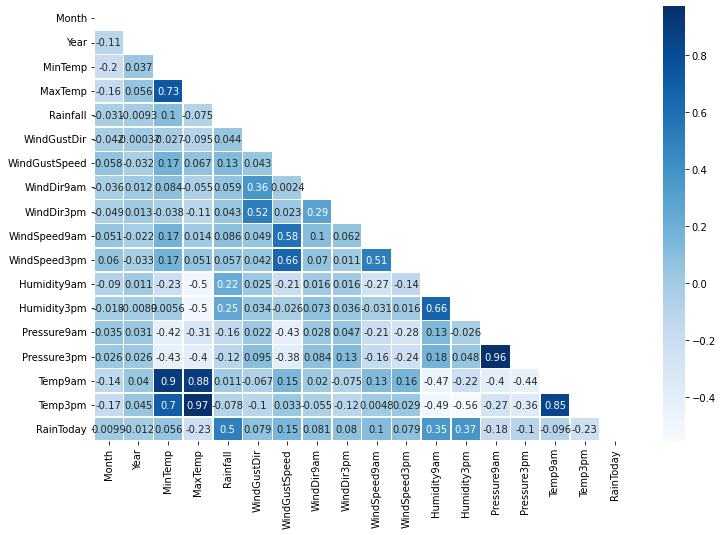

In [ ]:
#@title
#triu copia la matriz diagonal, ones_like copia matriz pero con 1, coor Calcular la correlación de columnas por pares, excluyendo NA / valores nulos
fig, ax = plt.subplots(figsize=(12,8))
mask = np.triu(np.ones_like(data.corr(), dtype=np.bool)) 
sns.heatmap(data.corr(), annot=True, cmap="Blues", mask=mask, linewidth=0.5)

De la matriz de correlación anterior podemos sacar varias conclusiones, por ejemplo \\
 `MinTemp` y `Temp9am`  tienen una correlación del 90% \\
 `MaxTemp` y `Temp3pm` tienen una correlación de 98% \\
 `Temp9am` y `Temp3pm` tienen una correlación de 86% \\
 `Pressure3pm` y `Pressure9am` tienen una correlación de 96% \\
 Queremos eliminar correlaciones altas y del análisi anterior pordemos borrar las caracteristicas: `Temp9am`, `Temp3pm`, `Pressure9am`, junto con la variables `Rainfall` que ya a habíamos discutido.

In [ ]:
#@title
data.drop(['Rainfall', 'Temp9am', 'Temp3pm', 'Pressure9am'], axis=1, inplace=True)
#implace Si es falso, devuelva una copia. De lo contrario, haga la operación

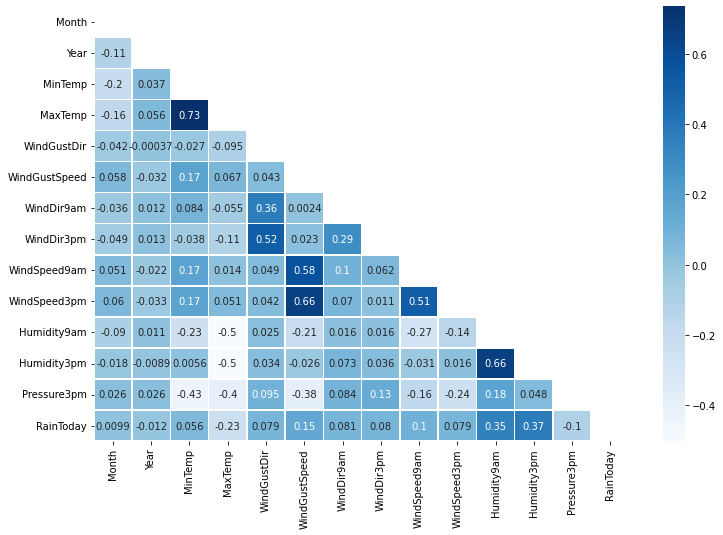

In [ ]:
#@title
fig, ax = plt.subplots(figsize=(12,8))
mask = np.triu(np.ones_like(data.corr(), dtype=np.bool)) 
sns.heatmap(data.corr(), annot=True, cmap="Blues", mask=mask, linewidth=0.5)

Veamos una gráfica para ver la información de nuestra vaiable objetivo. También un diagrama de calor de nuestros datos con nuestros datos limpios.

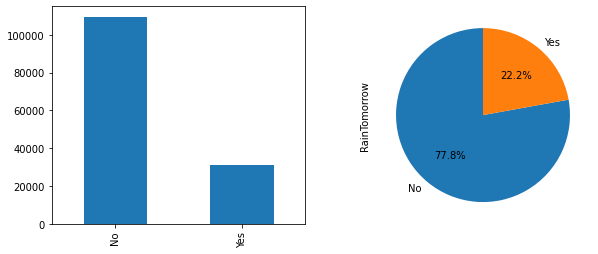

In [ ]:
#@title
fig, axs = plt.subplots(ncols=2, figsize=(10,4))
data['RainTomorrow'].value_counts().plot(kind='bar', ax=axs[0])
data['RainTomorrow'].value_counts().plot.pie(autopct='%1.1f%%', startangle = 90, ax=axs[1])

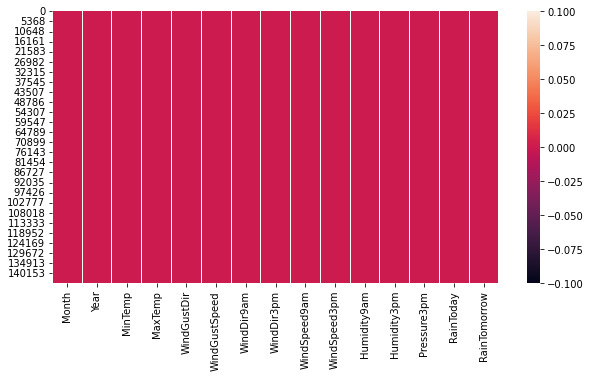

In [ ]:
#@title
plt.figure(figsize=(10,5))
sns.heatmap(data.isnull());

# Entrenamiento 

In [ ]:
#@title
data

,Month,Year,MinTemp,MaxTemp,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure3pm,RainToday,RainTomorrow
0,12,2008,13.4,22.9,180.0,44.0,180.0,157.5,20.0,24.0,71.0,22.0,1007.1,0,No
1,12,2008,7.4,25.1,157.5,44.0,112.5,202.5,4.0,22.0,44.0,25.0,1007.8,0,No
2,12,2008,12.9,25.7,202.5,46.0,180.0,202.5,19.0,26.0,38.0,30.0,1008.7,0,No
3,12,2008,9.2,28.0,45.0,24.0,315.0,0.0,11.0,9.0,45.0,16.0,1012.8,0,No
4,12,2008,17.5,32.3,180.0,41.0,22.5,135.0,7.0,20.0,82.0,33.0,1006.0,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,6,2017,3.5,21.8,0.0,31.0,337.5,0.0,15.0,13.0,59.0,27.0,1021.2,0,No
145455,6,2017,2.8,23.4,0.0,31.0,315.0,22.5,13.0,11.0,51.0,24.0,1020.3,0,No
145456,6,2017,3.6,25.3,112.5,22.0,315.0,90.0,13.0,9.0,56.0,21.0,1019.1,0,No
145457,6,2017,5.4,26.9,90.0,37.0,315.0,157.5,9.0,9.0,53.0,24.0,1016.8,0,No


In [ ]:
#@title
X = data[['Year','Month','MinTemp','MaxTemp','WindGustDir','WindGustSpeed',
          'WindDir9am','WindDir3pm','WindSpeed9am','WindSpeed3pm','Humidity9am',
          'Humidity3pm','Pressure3pm','RainToday']]

y = data['RainTomorrow']

In [ ]:
#@title
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def metricas(model,X_train, X_test, y_train, y_test,plot):
    '''
    Entrena el modelo y devuelve matriz de confusión, puntaje score, recall, presicion, puntaje f1
    '''    

    model.fit(X_train,y_train)

    y_predict = model.predict(X_test)

    plot_confusion_matrix(model, X_test, y_test, cmap="Blues")
    plt.grid(None)
    
    print(f"train score: {model.score(X_train, y_train)}")
    print(f"validation score: {model.score(X_test, y_test)}")  
    #print(f" Matriz de confución \n {confusion_matrix(y_test, y_predict)}\n")
    print(f" {classification_report(y_test, y_predict)} ")
    
    if (plot==True):
        plt.figure(figsize=(12,8))
        plot_tree(model.fit(X_train,y_train), feature_names=['Year','Month','MinTemp','MaxTemp','WindGustDir','WindGustSpeed',
          'WindDir9am','WindDir3pm','WindSpeed9am','WindSpeed3pm','Humidity9am',
          'Humidity3pm','Pressure3pm','RainToday'], filled=True);

train score: 0.9999822425840592
validation score: 0.7832232402869522
               precision    recall  f1-score   support

          No       0.86      0.86      0.86     21897
         Yes       0.51      0.53      0.52      6261

    accuracy                           0.78     28158
   macro avg       0.69      0.69      0.69     28158
weighted avg       0.79      0.78      0.78     28158
 


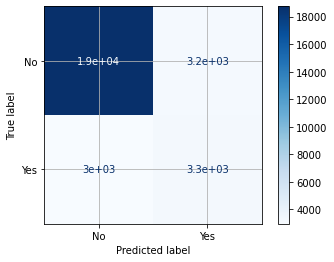

In [ ]:
#@title
metricas(DecisionTreeClassifier(),X_train, X_test, y_train, y_test,plot=False)

In [ ]:
#@title
parameters = { "splitter" : [ "best" , "random" ], 
            "max_depth"  :  [4,5,6,7,8,9,10,11,12], 
           "criterion" : ['gini', 'entropy'],
           'ccp_alpha':np.linspace(0, 4, 10)  }
GS = GridSearchCV(DecisionTreeClassifier(), parameters, scoring="accuracy")

GS.fit(X_train, y_train)

print(f"Parametros {GS.best_params_}")

Parametros {'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': 8, 'splitter': 'best'}


Veamos los resultados del árbol de decisión con los hiperparámetros óptimos...

train score: 0.8488399968036652
validation score: 0.8407202216066482
               precision    recall  f1-score   support

          No       0.86      0.95      0.90     21897
         Yes       0.74      0.44      0.55      6261

    accuracy                           0.84     28158
   macro avg       0.80      0.70      0.73     28158
weighted avg       0.83      0.84      0.83     28158
 


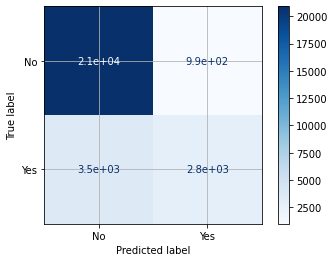

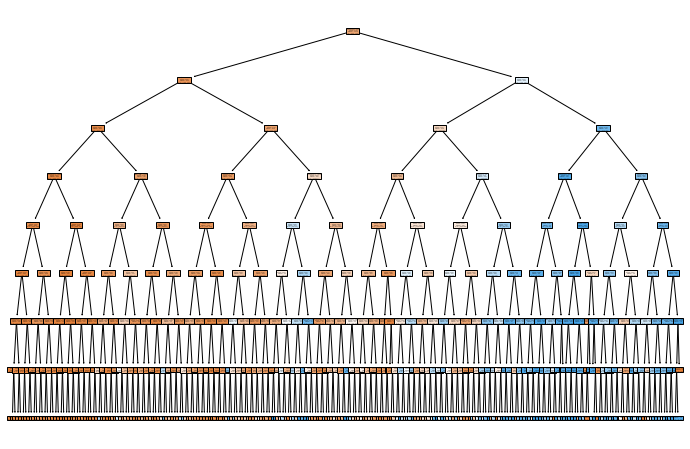

In [ ]:
#@title
metricas(DecisionTreeClassifier(ccp_alpha=0.0, criterion='entropy', max_depth=8,
                                splitter='best'),X_train, X_test, y_train, y_test,plot=True)

Como se puede observar, se disminuye el score en el conjunto de entrenamiento y se aumenta en el de validación, es decir, se disminuyó el overfitting.

In [ ]:
#@title
ADD = DecisionTreeClassifier(ccp_alpha=0.0, criterion='entropy', max_depth=8,
                                splitter='best').fit(X, y)

print("Característica", "\t", "Importancia")
for caract, imp in zip(data.columns, ADD.feature_importances_):
    print(caract, "\t", imp)

Característica 	 Importancia
Month 	 0.0008271482771461108
Year 	 0.002428329172658449
MinTemp 	 0.016077789088860747
MaxTemp 	 0.016261018490060862
WindGustDir 	 0.004543418201292621
WindGustSpeed 	 0.11734786006281614
WindDir9am 	 0.009800058254994103
WindDir3pm 	 0.015562616153362232
WindSpeed9am 	 0.0017773731694639126
WindSpeed3pm 	 0.007106885886827851
Humidity9am 	 0.01496441390620444
Humidity3pm 	 0.6611157440771367
Pressure3pm 	 0.08922626468995977
RainToday 	 0.04296108056921613


In [ ]:
#@title
cross_val_score(DecisionTreeClassifier(), X, y, cv=5)

array([0.76543078, 0.74469067, 0.76531591, 0.77543772, 0.77387506])

## Exploremos algunos métodos de ensamble...



<p><img alt="Colaboratory logo" height="350px" src="https://cdn.educba.com/academy/wp-content/uploads/2019/11/bagging-and-boosting.png" align="left" hspace="10px" vspace="0px"></p>

## Bagging

In [ ]:
#@title
'''
Optmización hiperparametros 
parameters = { 'n_estimators' : [100,200]}

GS = GridSearchCV(BaggingClassifier(base_estimator=DecisionTreeClassifier()), parameters, scoring="accuracy")

GS.fit(X_train, y_train)

print(f"Parametros {GS.best_params_}")
'''

train score: 0.8546022782764652
validation score: 0.8435968463669294
               precision    recall  f1-score   support

          No       0.86      0.95      0.90     21897
         Yes       0.74      0.46      0.56      6261

    accuracy                           0.84     28158
   macro avg       0.80      0.71      0.73     28158
weighted avg       0.83      0.84      0.83     28158
 


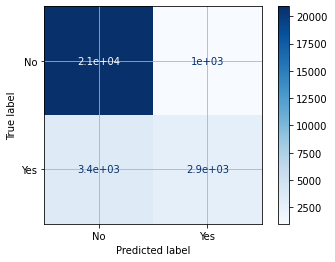

In [ ]:
#@title
ADD = DecisionTreeClassifier(ccp_alpha=0.0, criterion='entropy', max_depth=8,splitter='best')
BAG = BaggingClassifier(base_estimator=ADD)
metricas(BAG,X_train, X_test, y_train, y_test,plot=False) 

## Random Forest

In [ ]:
#@title
'''
Optmización hiperparametros
ADD = DecisionTreeClassifier(ccp_alpha=0.0, criterion='entropy', max_depth=8,splitter='best')
RF = RandomForestClassifier(base_estimator=ADD)

parameters = {'max_features': ['auto', 'sqrt'], 'n_estimators': [100, 200]}
GS = GridSearchCV(RF, parameters, scoring="accuracy")
GS.fit(X_train, y_train)
print(f"Parametros {GS.best_params_}")
'''

train score: 0.8507933125571567
validation score: 0.8413239576674479
               precision    recall  f1-score   support

          No       0.85      0.97      0.90     21897
         Yes       0.78      0.40      0.53      6261

    accuracy                           0.84     28158
   macro avg       0.81      0.68      0.72     28158
weighted avg       0.83      0.84      0.82     28158
 


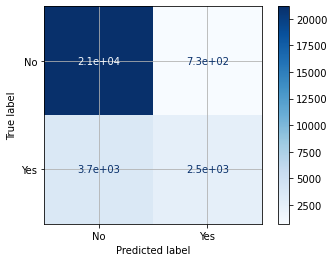

In [ ]:
#@title
#ADD = DecisionTreeClassifier(ccp_alpha=0.0, criterion='entropy', max_depth=8,splitter='best')
RF = RandomForestClassifier(ccp_alpha=0.0, criterion='entropy', max_depth=8)
metricas(RF,X_train, X_test, y_train, y_test,plot=False)

# XGboost

In [ ]:
#@title
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

train score: 0.8497900185564996
validation score: 0.844626749058882
               precision    recall  f1-score   support

          No       0.86      0.95      0.91     21897
         Yes       0.74      0.46      0.57      6261

    accuracy                           0.84     28158
   macro avg       0.80      0.71      0.74     28158
weighted avg       0.83      0.84      0.83     28158
 


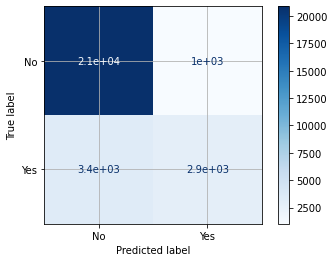

In [ ]:
#@title
metricas(XGBClassifier(),X_train, X_test, y_train, y_test,plot=False)

In [ ]:
#@title
'''
Optmización hiperparametros
XGB = GridSearchCV(XGBClassifier(base_estimator=DecisionTreeClassifier()), parameters, scoring="accuracy")

XGB.fit(X_train, y_train)

print(f"Parametros {XGB.best_params_}")
'''

'\nXGB = GridSearchCV(XGBClassifier(base_estimator=DecisionTreeClassifier()), parameters, scoring="accuracy")\n\nXGB.fit(X_train, y_train)\n\nprint(f"Parametros {XGB.best_params_}")\n'

<p><img alt="Colaboratory logo" height="350px" src="https://cdn.analyticsvidhya.com/wp-content/uploads/2017/06/11194227/depth.png" align="left" hspace="10px" vspace="0px"></p>






# Conclusión. 
No se evidencia mejora en el score con lo modelos de Bagging y Boosting. 

El modelo de arboles de decisión le da mayor importancia a la variable que contiene la humedad a las 3 pm, con un score de $0.84$ en los datos de validación. 